## PCA Streaming on microcontroller
This notebook communicates through UART to a MCU to assess the performance of PCA streaming methods

In [1]:
import numpy as np
from scipy import linalg
import pandas as pd
import micro_pylib.metrics as mt
import micro_pylib.stream as stream
import os
import time
import matplotlib.pyplot as plt

### Test setup and parameters
Use this section to select the parameters for the test
- baud_rate: UART baud rate in bit/s
- serial_port: string containing the name of the serial port (e.g., "COM5")
- minor: True when searching for the minor subspace, False when searching for the principal
- method: the method to be used among
    - Oja
    - Krasulina
    - ISVD
    - PAST
    - GROUSE
    - OjaMinor
    - KrasulinaMinor
    - HFRANS
- rho: noise level
- steps: number of total updates

In [2]:
# ~ MPU serial ~

baud_rate   = 4000000
serial_port = "COM5"


# ~ Method setup ~

minor = False
method = "PAST"
rho = 1e-3
steps = 1000

### Initialization

In [3]:
# *** GENERIC SETUP ************************************************************

# ~ Numpy print options ~

np.set_printoptions(
    edgeitems=3,
    linewidth=200,
    precision=3,
    )
    
    
# ~ Generate output folders ~

os.makedirs("data", exist_ok=True)
os.makedirs("results", exist_ok=True)


# ~ Open a stream to the micro ~

micro = stream.Stream(
    serial_port,
    baud_rate=baud_rate,
    timeout=5,
    )


# *** METHODS SELECTION ********************************************************

# ~ Methods dictionaries ~

methods_dict = {
    "Oja":            0,
    "Krasulina":      1,
    "ISVD":           2,
    "PAST":           3,
    "GROUSE":         4,
    }
methods_minor_dict = {
    "OjaMinor":       5,
    "KrasulinaMinor": 6,
    "HFRANS":         7,
    }
    
    
# ~ Check for the existence of the requested method and select method_id ~
    
if not minor:
    if method not in methods_dict:
        print(f"> (!) Method '{method}' is not a valid "+
               "principal subspace identification method. Quitting...")
        exit()
    else:
        method_id = methods_dict.get(method, -1)
else:
    if method not in methods_minor_dict:
        raise(f"> (!) Method '{method}' is not a valid "+
               "minor subspace identification method. Quitting...")
        exit()
    else:
        method_id = methods_minor_dict.get(method, -1)
    

# *** Test Loop Initialization *************************************************

# ~ Request method to micro ~

print(f"> Requesting {method} (id = {method_id}) to micro.")
micro.write_value(method_id)

    
# ~ Send to micro the number of steps ~

print(f"> Requesting {steps} iterations to micro.")
micro.write_value(steps)

            
# ~ Ask to micro matrix size and input matrix ~

n = micro.read_value()
k = micro.read_value()
m = n-k if minor else k
print(f"> Received n = {n}, k = {k}, m = {m} " +
       "(minor) "*minor + "from micro.")


# ~ Load or generate matrix Phi ~

filename = os.path.join("data", f"Phi{n}x{m}.npy")
if os.path.isfile(filename):
    print("> Loading matrix Phi")
    Phi = np.load(filename)
else:
    print("> Generating and saving matrix Phi")
    Phi = np.linalg.qr(np.random.randn(n, m))[0]
    np.save(filename, Phi)

    
# ~ Evaluate target matrix

U = linalg.null_space(Phi.T) if minor else Phi
      
      
# ~ Load or generate initialization matrix Uinit ~

filename = os.path.join("data", f"Uinit{n}x{k}.npy")
if os.path.isfile(filename):
    print("> Loading matrix Uinit")
    Uinit = np.load(filename)
else:
    print("> Generating and saving matrix Uinit")
    Uinit = np.linalg.qr(np.random.randn(n, k))[0]
    np.save(filename, Uinit)
    
    
# ~ Load or generate input batch xbatch ~

filename = os.path.join("data", f"xbatch{steps}Phi{n}x{m}rho{rho:.1e}.npy")
if os.path.isfile(filename):
    print("> Loading batch of signals")
    xbatch = np.load(filename)
else:
    print("> Generating and saving batch of signals")
    sig = np.random.randn(m, steps)
    nu = rho*np.random.randn(steps, n)
    xbatch = (Phi@sig).T+nu
    np.save(filename, xbatch)

# ~ Send Uinit to micro ~

print("> Sending Uinit to micro")
if method == "ISVD":
    micro.write_matrix(Uinit.T)
else:
    micro.write_matrix(Uinit)
                
# ~ Initialize results dataframe ~
pca_results = pd.DataFrame()

Opening serial port to micro...
> Requesting PAST (id = 3) to micro.
> Requesting 1000 iterations to micro.
> Received n = 100, k = 10, m = 10 from micro.
> Generating and saving matrix Phi
> Generating and saving matrix Uinit
> Generating and saving batch of signals
> Sending Uinit to micro


### Test Loop

In [4]:
print(f"\n*** TESTING {method} METHOD with n = {n}, m = {m}, k = {k} ***") 

for it in range(1, steps+1):
    
    # ~ Send input vector to micro ~
    micro.write_vector(xbatch[it-1])

    # ~ Receive estimated matrix Ut ~
    if method == "ISVD":
        Ut = micro.read_matrix(k, n).T
    else:
        Ut = micro.read_matrix(n, k)

    # *** Print error on subspace ***  
    error_u = np.linalg.norm(U-Ut@Ut.T@U)
    error_orth = np.linalg.norm(np.eye(k)-Ut.T@Ut)
    print(f"> Step {it}/{steps} > " +
          f"Error on subspace = {error_u:8.3e}, " + 
          f"orthonormality error = {error_orth:8.3e}", end = "\r", flush=True)
    
    # *** Store results
    res = {
        "error_u": error_u,
        "error_orth": error_orth,
        }
    pca_results = pca_results.append(res, ignore_index=True)
    
print(end = "\n")

# *** SAVE RESULTS TO FILE *****************************************************

print("> Saving results to file")
filename = os.path.join(
    "results", "{}_U{}x{}_rho{:.1e}_steps{}.csv".format(
        method,
        n,
        k,
        rho,
        steps,
        )
    )
pca_results.to_csv(filename, index=False)
        
print("> All jobs done.")

micro.close()


*** TESTING PAST METHOD with n = 100, m = 10, k = 10 ***
> Step 1000/1000 > Error on subspace = 2.184e-03, orthonormality error = 1.534e-06
> Saving results to file
> All jobs done.
Closing serial port to micro...


### Print result

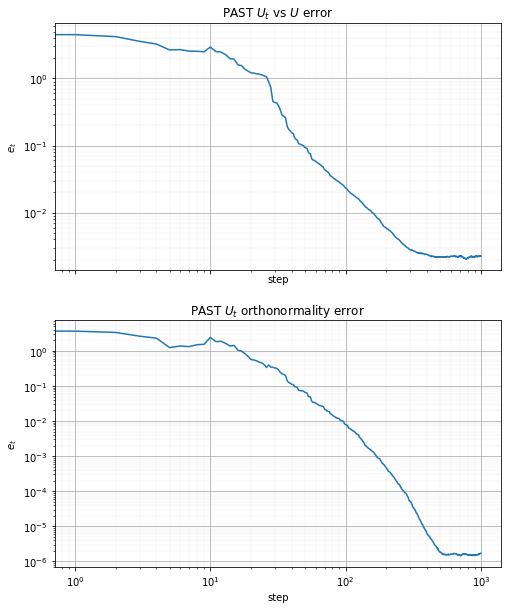

In [5]:
fig, axs = plt.subplots(2, 1, figsize = (8, 10), sharex = True)

axs[0].plot(pca_results["error_u"])
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].grid(which="major")
axs[0].grid(which="minor", linewidth = 0.1)
axs[0].set_title(f"{method} $U_t$ vs $U$ error")
axs[0].set_xlabel("step")
axs[0].set_ylabel("$e_t$")

axs[1].plot(pca_results["error_orth"])
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].grid(which="major")
axs[1].grid(which="minor", linewidth = 0.1)
axs[1].set_title(f"{method} $U_t$ orthonormality error")
axs[1].set_xlabel("step")
axs[1].set_ylabel("$e_t$")

print()